In [1]:
import os
username = os.getlogin()
executable_path = f"/home/{username}/.sdkman/candidates/java/current/bin"

if executable_path not in os.environ["PATH"]:
    os.environ["PATH"] = f"{executable_path}:{os.environ['PATH']}"

from scipy.signal import cont2discrete, lti, dstep # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [2]:
# dati Carlo by maxon https://www.maxongroup.com/maxon/view/product/motor/dcmotor/re/re25/339150
Ra = 0.517 # Armature resistance [Ohm]
La = 0.0573e-3 # Winding inductance [Henry]
Kb = 1 / (828*2*np.pi/60) # [V/(rad/s)] - Motor's back EMF constant 
#print(Kb)
B = 0.001 # Damping in the motor load
J = 14.5e-7 # Motor inertia [Kg * m^2] - convertito dalle specs
Ktau = 11.5e-3 # [N*m/A] - convertito dalle specs - Torque constant that relates to the armature current

# dati Alberto
Ra = 5 # Armature resistance [Ohm]
La = 10e-3 # Winding inductance [Henry]
Kb = 0.1 # Motor's back EMF constant 
B = 0.05 # Damping in the motor load
J = 0.01 # Motor inertia [Kg m^2]
Ktau = 5 # Torque constant that relates to the armature current


In [3]:
ss_A = np.array([
    [-Ra/La, 0, -Kb/La],
    [0, 0, 1],
  # [Ktau, 0, -B/J]    nel paper era diverso il primo termine, vedi sotto
    [Ktau/J, 0, -B/J]
])
ss_B = np.array([[1/La, 0, 0]]).T
ss_C = np.array([0, 1, 0])
ss_D = 0

dt = 0.1

l_system = lti(ss_A, ss_B, ss_C, ss_D)
d_system = cont2discrete((ss_A, ss_B, ss_C, ss_D), dt, method="zoh")

In [4]:
ss_A, np.linalg.eig(ss_A)

# è instabile perchè un polo è in 0
# Verifica se tutti i valori propri hanno una parte reale negativa
eigenvalues, eigenvectors = np.linalg.eig(ss_A)
if np.all(np.real(eigenvalues) < 0):
    print("Il sistema è stabile")
else:
    print("Il sistema non è stabile")


Il sistema non è stabile


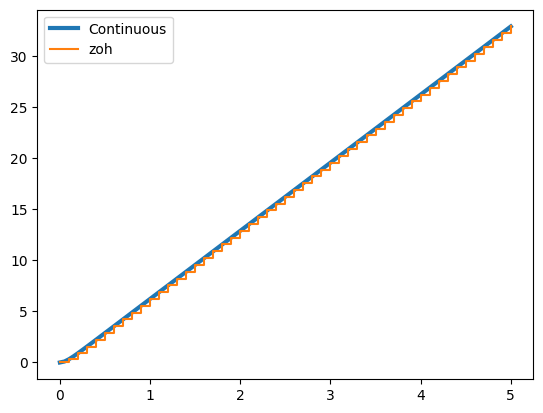

In [5]:
t, x = l_system.step(T=np.linspace(0, 5, 100))

fig, ax = plt.subplots()
ax.plot(t, x, label='Continuous', linewidth=3)


s, x_d = dstep(d_system, t=t)
ax.step(s, np.squeeze(x_d), label="zoh", where='post')

ax.legend(loc='best')
plt.show()

In [6]:
def pid(error, previous_error, parameters):
    Kp, Ki, Kd = parameters

    tension = Kp * error + Ki * (error + previous_error) + Kd * (error - previous_error)

    return tension

In [7]:
import warnings

def simulate_system(target, time_steps, initial_state, system_params, pid_func, d_system):
    """Simula il sistema per un dato target e restituisce Y e U."""
    warnings.simplefilter("error", RuntimeWarning)
    x = initial_state
    y = np.array([0])
    u = np.array([0])
    p_err = np.array([0])

    Y = []
    U = []

    try:
        for t in range(time_steps):
            # Calculate the system output
            y = d_system[2] @ x
            Y.append(y)

            # Compute the error
            error = target - y 

            # Use the PID to find the new input
            u = pid_func(error, p_err, system_params)
            U.append(u)
            p_err = error

            # Compute the new state
            x = d_system[0] @ x + d_system[1] @ u.reshape(1, 1)

        Y = np.array(Y).reshape(-1)
        U = np.array(U).reshape(-1)

        return Y, U

    except Exception as e:
        print(f"Error with parameters {system_params} at iteration {t}: {e}")
        print(f"  State vector (x): {x.flatten()}")
        print(f"  Output (y): {y}")
        print(f"  PID output (u): {u}")
        return None, None

# Parametri iniziali
X0 = np.array([[0, 0, 0]]).T
Ys = []
Us = []

TIME_STEPS = 100
NO_OVERSHOOT_SLOW = (0.02, 0.03, 0.2)
QUICK_NO_OVERSHOOT = (1, 0.03, 0.2)
RESONANCE = (10, 0, 0) # con 100 va in overflow

for parameters in [NO_OVERSHOOT_SLOW, QUICK_NO_OVERSHOOT, RESONANCE]:
    Y, U = simulate_system(target=np.pi, time_steps=TIME_STEPS, initial_state=X0, 
                           system_params=parameters, pid_func=pid, d_system=d_system)
    if Y is not None and U is not None:
        Ys.append(Y)
        Us.append(U)

time = np.linspace(0, TIME_STEPS * 0.1, num=len(Ys[0]) if Ys else 0)


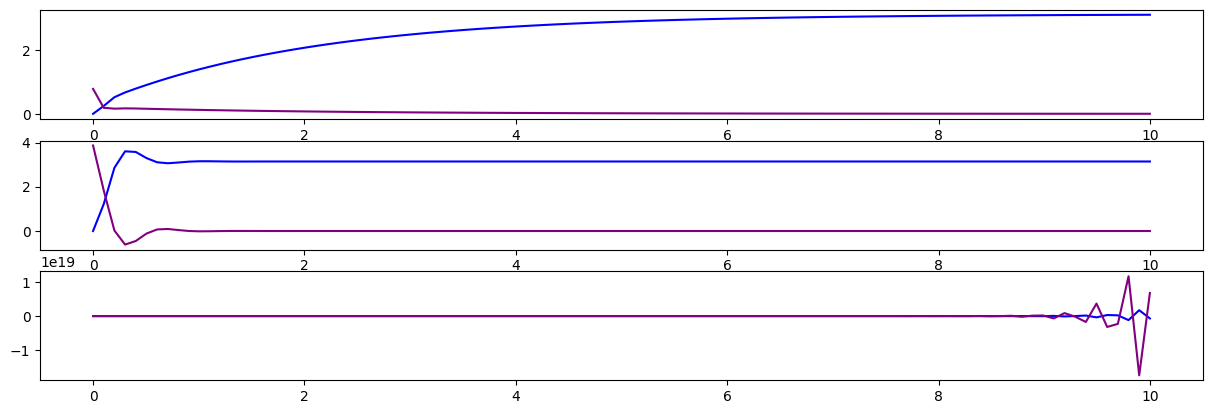

In [8]:
plt.figure(figsize=(15, 15))

#print(np.array(Us).shape)

for i in range(len(Ys)):
    plt.subplot(9, 1, i+1)
    plt.plot(time, Ys[i], label = '$y(t)$',color='blue')
    plt.plot(time, Us[i], label = '$u(t)$',color='purple')

# Requirements that a controller should satisfy

1. No overshoot
2. Should be quick

In [9]:
import moonlight # type: ignore

In [10]:
script = """
signal { real x;}
domain boolean; 
formula Overshoot = eventually [0,10] { globally [0, 0.1]  (x > 3.15) };
formula Resonance = eventually [0,1] globally[0,90] ((3.1 <= x) & (x <= 3.18));
"""

moonlightScript = moonlight.ScriptLoader.loadFromText(script)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

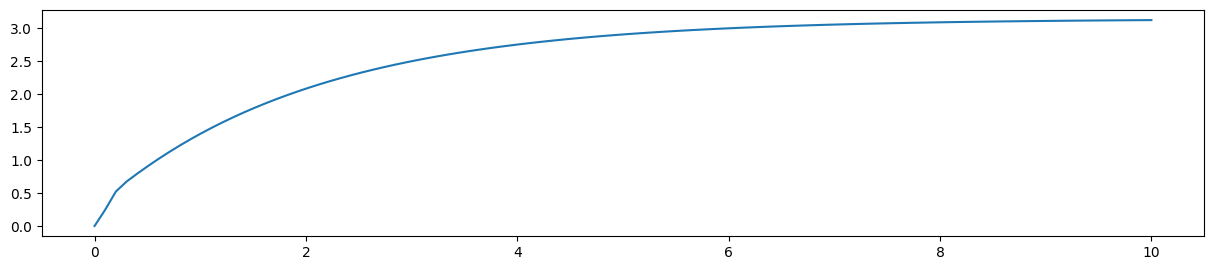

In [12]:
## STEP 4: getting the monitor associated with a target formula

MONITOR_NAMES = ["Overshoot", "Resonance"]

plt.rcParams["figure.figsize"] = (15,10)
for i in range(len(Ys)):
    plt.subplot(3, 1, i+1)

    plt.plot(time,Ys[i])

    signals = list(zip(Ys[i]))
    monitors = []
    results = []
    for m in MONITOR_NAMES:
        monitor = moonlightScript.getMonitor(m)
        monitors.append(monitor)
        result = np.array(monitor.monitor(list(time),signals))
        results.append(result)

    for i in range(len(results)):
        r = results[i]
        plt.step(r[:,0],r[:,1], where='post', label=MONITOR_NAMES[i])


    plt.title("Plot of Monitor")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend()


: 

: 